In [1]:
import scripts.end2end.oze as script

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np


# Reload python packages when changed
%load_ext autoreload
%autoreload 2

# Matplotlib defaults
plt.rcParams.update({
    "font.size": 25,
    "figure.figsize": (14, 7),
    "axes.grid": True,
    "grid.color": "#93a1a1",
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

In [2]:
script.Experiment.exp_name = "oze-visu"
exp = script.Experiment(script.parser.parse_args(["--gpus", "0", "--batch-size", "3"]))

Using logger <aim.sdk.adapters.pytorch_lightning.AimLogger.__get_logger_cls.<locals>._PytorchLightningLogger object at 0x7fa6b45b0880>.


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mrmojo/Code/these/vqvae/vqvae/.env/lib64/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [3]:
def plot_range(arrays, p=0.05, alpha=1, **kwargs):
    N = arrays.shape[-1]
    arrays = np.sort(arrays, axis=-1)[:, int(p*N):-int(p*N)]
    plot_min = arrays.min(axis=-1)
    plot_max = arrays.max(axis=-1)
    plot_mean = arrays.mean(axis=-1)
    plt.fill_between(x=np.arange(len(plot_min)), y1=plot_min, y2=plot_max, alpha=alpha, **kwargs)
    plt.plot(plot_mean, lw=3, **kwargs)

In [4]:
def plot_sigma(mean, sigma, alpha=1, **kwargs):
    plot_min = dataloader.dataset.rescale(mean - 3*sigma, label="observation").squeeze()
    plot_max = dataloader.dataset.rescale(mean + 3*sigma, label="observation").squeeze()
    plot_mean = dataloader.dataset.rescale(mean, label="observation").squeeze()
    plt.fill_between(np.arange(len(plot_mean)), plot_min, plot_max, alpha=alpha, **kwargs)
    plt.plot(plot_mean, lw=3, **kwargs)

In [5]:
litmodule = script.LitOzeFull.load_from_checkpoint("checkpoints/oze-end2end-sigma/last.ckpt", vqvae=exp.litmodule.vqvae, prior=exp.litmodule.prior)
litmodule.vqvae.eval()
litmodule.prior.eval()

dm = exp.datamodule
dm.setup()

dataloader = dm.train_dataloader()

/home/mrmojo/Code/these/vqvae/vqvae/src/oze/utils.py:69: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  occupancy = int(date < date_start_lockdown)
/home/mrmojo/Code/these/vqvae/vqvae/src/oze/utils.py:72: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date_end_lockdown < date:


In [6]:
for batch in dataloader:
    commands, observations = batch
    break

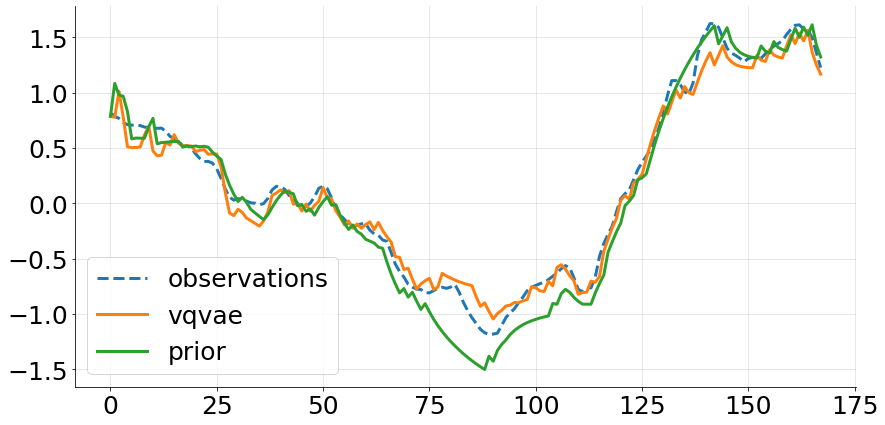

In [7]:
idx_sample = 0
with torch.no_grad():
    encoding = litmodule.vqvae.encode(observations)
    quantized, indices, _ = litmodule.vqvae.codebook.quantize(encoding)
    indices = indices.argmax(-1)

    sample = litmodule.prior(commands, indices=indices)
    # sample = litmodule.prior(torch.zeros(commands.shape), indices=indices)
    sample, sigma = litmodule.vqvae.decode(litmodule.vqvae.codebook(sample.argmax(-1)))
    
    reconstructions, sigma_recon = litmodule.vqvae.decode(quantized)

plt.plot(observations[:, idx_sample].squeeze().numpy(), "--", lw=3, label="observations")
plt.plot(reconstructions[:, idx_sample].squeeze().numpy(), '-', lw=3, label="vqvae")
plt.plot(sample[:, idx_sample].squeeze().numpy(), lw=3, label="prior")
plt.legend()
plt.show()

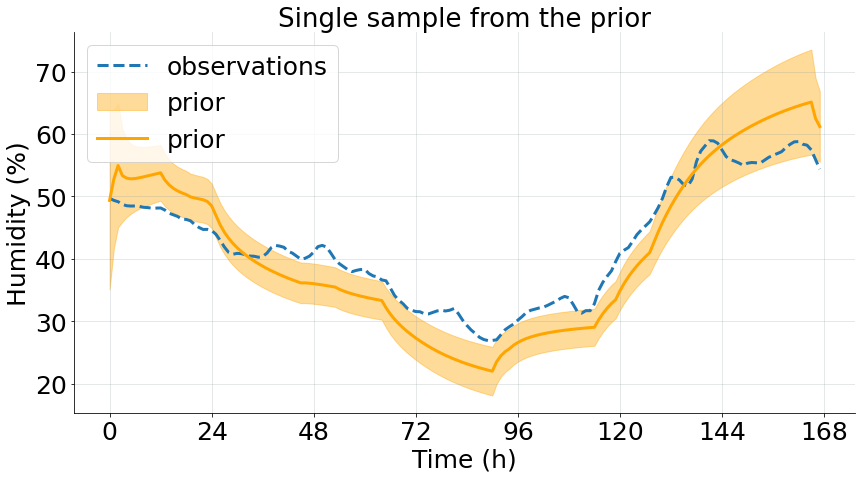

In [8]:
with torch.no_grad():
    encoding = litmodule.vqvae.encode(observations)
    quantized, indices, _ = litmodule.vqvae.codebook.quantize(encoding)
    indices = indices.argmax(-1)
    sample = litmodule.prior.forward(commands, indices=indices, generate=True, step_sample=False)
    # sample = litmodule.prior.forward(torch.zeros(commands.shape), indices=indices, generate=True, step_sample=False)
    sample, sigma = litmodule.vqvae.decode(litmodule.vqvae.codebook(sample.argmax(-1)))
    
    reconstructions, _ = litmodule.vqvae.decode(quantized)

plt.plot(dataloader.dataset.rescale(observations[:, idx_sample].numpy(), label="observation").squeeze(), "--", lw=3, label="observations")
# plt.plot(reconstructions[:, idx_sample].squeeze().numpy(), '--', lw=3, label="vqvae")
# plt.plot(sample[:, idx_sample].squeeze().numpy(), label="prior")
plot_sigma(sample[:, idx_sample].numpy().squeeze(), sigma[:, idx_sample].numpy().squeeze(), alpha=.4, color="orange", label="prior")
plt.title("Single sample from the prior", fontsize=26)
plt.xticks(np.arange(0, len(sample)+1, 24))
plt.xlabel("Time (h)")
plt.ylabel("Humidity (%)")
plt.legend()
plt.show()

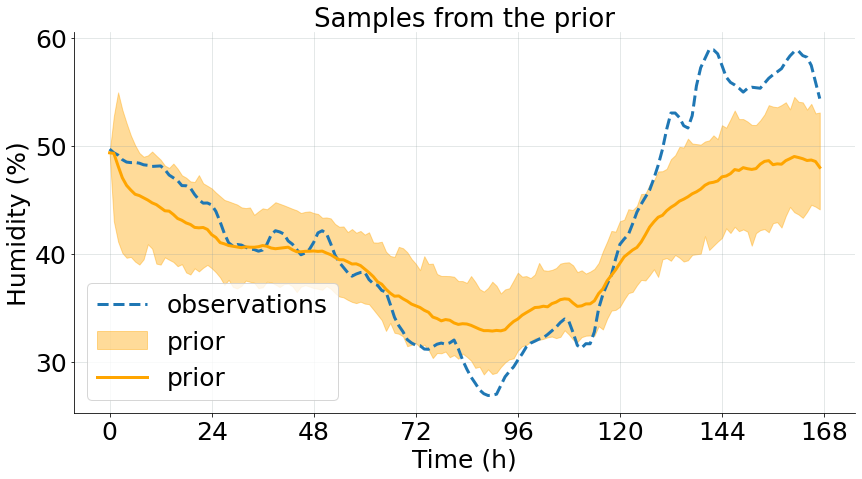

In [9]:
n_samples = 100
with torch.no_grad():
    encoding = litmodule.vqvae.encode(observations)
    quantized, indices, _ = litmodule.vqvae.codebook.quantize(encoding)
    indices = indices.argmax(-1)
    
    sample = litmodule.prior(commands=torch.stack([commands[:, idx_sample] for _ in range(n_samples)], dim=1),
                              indices=torch.stack([indices[:, idx_sample] for _ in range(n_samples)], dim=1),
                              generate=True,
                              step_sample=True,
                             )
    sample, sigma = litmodule.vqvae.decode(litmodule.vqvae.codebook(sample.argmax(-1)))
    
plt.plot(dataloader.dataset.rescale(observations[:, idx_sample].squeeze().numpy(), label="observation").squeeze(), "--", lw=3, label="observations")
plot_range(dataloader.dataset.rescale(sample.squeeze().numpy(), label="observation"), alpha=.4, label="prior", color='orange')
plt.title("Samples from the prior", fontsize=26)
plt.xticks(np.arange(0, len(sample)+1, 24))
plt.xlabel("Time (h)")
plt.ylabel("Humidity (%)")
plt.legend()
plt.show()